# MountainCar-v0

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

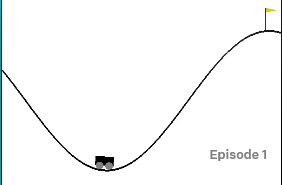

Source: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py



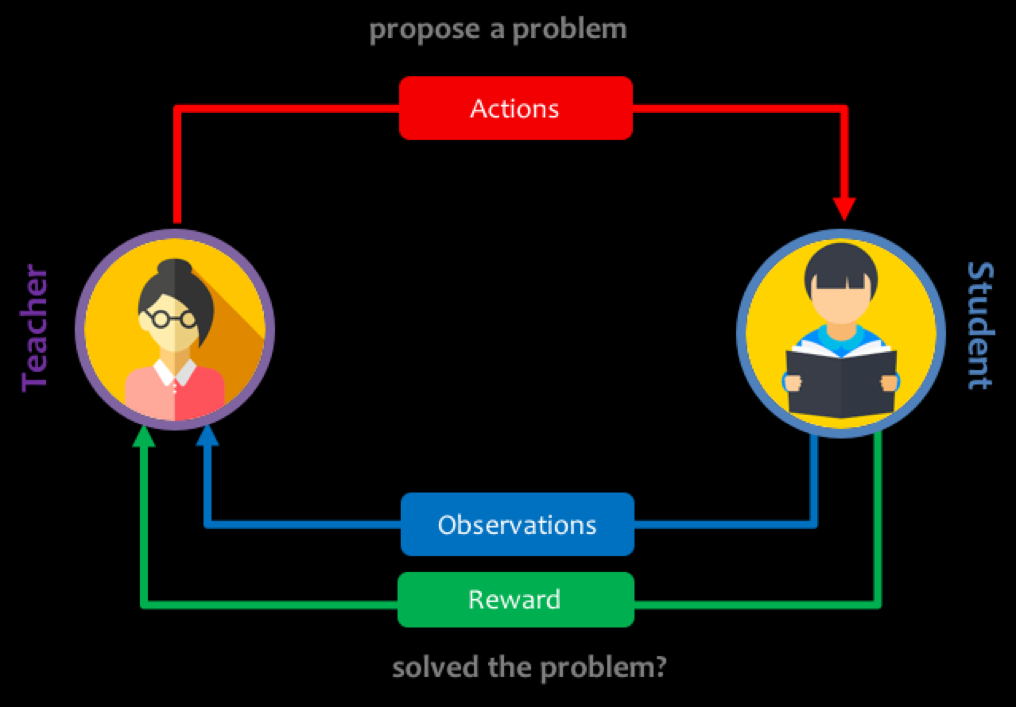


1. Student network: receives a task, and is expected to interact in the environment and learn how to solve it.

2. Teacher network: proposes tasks by observing the progress signal of the student and sampling new tasks that maximise this signal.

### **STUDENT**

The student can be any classical Deep Reinforcement Learning agent, as from its point of view, it is only expected to solve tasks provided to it. It will be trained end-to-end, using the extrinsic reward function of the task being tackled.

### **TEACHER**

The teacher should be able to follow the student progress, and propose tasks in a sequence which overall should lead to the student solving complex tasks it couldn’t before. It effectively needs to explore the space of tasks effectively, as depending on the expertise of the student the same task can be valuable or useless.

In [4]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import gym
import pygame
import os
from collections import deque

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM

STUDENT_LR = 0.05
TEACHER_LR = 0.09
TEACHER_PRECISION = 0.99
IMPROVEMENT_WEIGHT = 0.01
RANDOM_SEED = 6
TOTAL_EPISODES = 1000
TEACHER_OUTPUT_SIZE = 1
WIN_REWARD = -110
tf.config.run_functions_eagerly(True)

## Make the environment here

Set the random seed for reproducibility

In [5]:
env = gym.make('MountainCar-v0')
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
def one_hot_encoder(index, size):
    return tf.one_hot(indices=index, depth=size).numpy()

def make_student(state_shape, action_shape):
    model = Sequential()
    model.add(Dense(64, input_shape=state_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(action_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=STUDENT_LR), metrics=['accuracy'])
    return model


def make_teacher(state_shape, output_shape):
    model = Sequential()
    model.add(Dense(64, input_shape=state_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=TEACHER_LR), metrics=['accuracy'])
    return model

def CL_teacher(observation, nextObservation, teacherAgent, reward, done):
    obsvReshape = observation.reshape([1, observation.shape[0]])
    nextObsvReshape = nextObservation.reshape([1, nextObservation.shape[0]])
    
    currActionQuality = np.array(teacherAgent.predict(obsvReshape))[0]
    nextActionQuality = np.array(teacherAgent.predict(nextObsvReshape))[0]
    
    targetQuality = reward + (1-done)*TEACHER_PRECISION*nextActionQuality
    improvement = targetQuality-currActionQuality
    teacherAgent.fit(obsvReshape, np.vstack([targetQuality]), verbose=0)
    
    return improvement

def student_action(observation, studentAgent, env):
    
    obsvReshape = observation.reshape([1, observation.shape[0]])
    probAction = studentAgent.predict(obsvReshape).flatten()
    action = np.random.choice(env.action_space.n, 1, p=probAction)[0]
    oneHotAction = tf.one_hot(indices=action, depth=env.action_space.n).numpy()
    
    return action, probAction, oneHotAction
    
    
studentAgent = make_student(env.observation_space.shape, env.action_space.n)
teacherAgent = make_teacher(env.observation_space.shape, TEACHER_OUTPUT_SIZE)
cumEpisodeRewards = deque(maxlen=100)
total_episode_rewards = []

for episode in range(TOTAL_EPISODES):
    episodeReward = 0
    observation = env.reset()
    done = False
    
    while not done:
        # env.render()
        action, probAction, oneHotAction = student_action(observation, studentAgent, env)
        nextObservation, reward, done, _ = env.step(action)
        improvement = CL_teacher(observation, nextObservation, teacherAgent, reward, done)
        studentTarget = probAction + IMPROVEMENT_WEIGHT * (oneHotAction-probAction) * improvement
        studentAgent.fit(observation.reshape([1, observation.shape[0]]), np.vstack([studentTarget]), verbose=0)
        observation = nextObservation
        episodeReward += reward
        if done:
            print(f'Episode Reward={episodeReward} at episode {episode}')
            cumEpisodeRewards.append(episodeReward)
            total_episode_rewards.append(episodeReward)
            mean_score = np.mean(cumEpisodeRewards)
            
            if mean_score >= WIN_REWARD and episode >= 100:
                print(f'Total episodes: {episode} \n Solved after {episode-100} episodes!')
                break
env.close()
                
# if __name__ == '__main__':
#     main()       

Episode Reward=-200.0 at episode 0
Episode Reward=-200.0 at episode 1
Episode Reward=-200.0 at episode 2
Episode Reward=-200.0 at episode 3
Episode Reward=-200.0 at episode 4
Episode Reward=-200.0 at episode 5
Episode Reward=-200.0 at episode 6
Episode Reward=-200.0 at episode 7
Episode Reward=-200.0 at episode 8
Episode Reward=-200.0 at episode 9
Episode Reward=-200.0 at episode 10
Episode Reward=-200.0 at episode 11
Episode Reward=-200.0 at episode 12
Episode Reward=-200.0 at episode 13
Episode Reward=-200.0 at episode 14
Episode Reward=-200.0 at episode 15
Episode Reward=-200.0 at episode 16
Episode Reward=-200.0 at episode 17
Episode Reward=-200.0 at episode 18
Episode Reward=-200.0 at episode 19
Episode Reward=-200.0 at episode 20
Episode Reward=-200.0 at episode 21
Episode Reward=-200.0 at episode 22
Episode Reward=-200.0 at episode 23
Episode Reward=-200.0 at episode 24
Episode Reward=-200.0 at episode 25
Episode Reward=-200.0 at episode 26
Episode Reward=-200.0 at episode 27
Ep

KeyboardInterrupt: 

# Q-Learing

**Q-learning** is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. It does not require a model of the environment (hence "model-free"), and it can handle problems with stochastic transitions and rewards without requiring adaptations.   

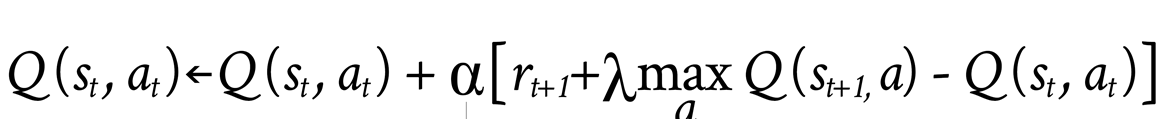

For any finite Markov decision process (FMDP), Q-learning finds an optimal policy in the sense of maximizing the expected value of the total reward over any and all successive steps, starting from the current state.

Q-learning can identify an optimal action-selection policy for any given FMDP, given infinite exploration time and a partly-random policy. "Q" refers to the function that the algorithm computes – the expected rewards for an action taken in a given state.

Episode:0 avg: -200.0 min: -200.0 max: -200.0
Episode:500 avg: -200.0 min: -200.0 max: -200.0
Episode:1000 avg: -200.0 min: -200.0 max: -200.0
Episode:1500 avg: -200.0 min: -200.0 max: -200.0
Episode:2000 avg: -200.0 min: -200.0 max: -200.0
Episode:2500 avg: -200.0 min: -200.0 max: -200.0
Episode:3000 avg: -200.0 min: -200.0 max: -200.0
Episode:3500 avg: -199.136 min: -200.0 max: -162.0
Episode:4000 avg: -198.634 min: -200.0 max: -154.0
Episode:4500 avg: -192.976 min: -200.0 max: -146.0
Episode:5000 avg: -189.56 min: -200.0 max: -139.0
Episode:5500 avg: -175.624 min: -200.0 max: -130.0
Episode:6000 avg: -180.232 min: -200.0 max: -125.0
Episode:6500 avg: -179.514 min: -200.0 max: -145.0
Episode:7000 avg: -180.86 min: -200.0 max: -137.0
Episode:7500 avg: -166.234 min: -200.0 max: -90.0
Episode:8000 avg: -155.96 min: -200.0 max: -92.0
Episode:8500 avg: -153.774 min: -200.0 max: -108.0
Episode:9000 avg: -165.718 min: -200.0 max: -108.0
Episode:9500 avg: -147.57 min: -200.0 max: -109.0


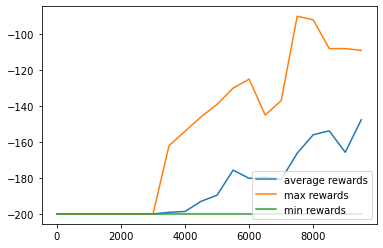

In [18]:
import gym
import numpy as np
import matplotlib.pyplot as plt

#Setting up the environment
env=gym.make("MountainCar-v0")

#All our variables and constants
#Model
learning_rate=0.1
discount=0.95
#Number of episodes for our agent to go through
episodes=10000
#Show an example on the screen every 2000 episodes
SHOW_EVERY = 500
#Our discrete bucketing of the observatrion space
DISCRETE_OS_SIZE=[30]*len(env.observation_space.high)
#Our increment for the bucketing
discrete_os_win_size=(env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE
#The epsilon to pilot the randomness of our actions to increase exploration to actually enable learning
epsilon = 1
#When do we start to decay epsilon in order to reduce randomness of the actions of our model
START_EPSILON_DECAYING = 1
#End of the decaying of our epsilon
END_EPSILON_DECAYING = episodes // 2
#Value of the devaying of our epsilon, by how much do we decrease epislon after each iteration 
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)
#Creation of our Q_table that will store all the different values of our environment space
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

#Additional objects for reporting purposes
ep_rewards = []
aggr_ep_rewards = {'ep':[], 'avg' : [], 'min' : [], 'max' : []}


#Quick helper-function that will convert our environment "state," which currently contains continuous 
#values that would wind up making our Q-Table absolutely gigantic and take forever to learn.... to a "discrete" state instead:
def get_discrete_state(state):
    discrete_state = (state-env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int64))

#Looping code for each episode
for episode in range(episodes):
    #Initialisation of the reward for current episode
    episode_reward=0
    #We print the episode number if we will show it as an example
    if episode%SHOW_EVERY ==0:
        #Show it
        # print(episode)
        render=True
    else:
        #not show it
        render=False
    #get the discrete_state
    discrete_state=get_discrete_state(env.reset())

    done=False

    while not done:
        #Selection of the action for our Cart 
        #Now we just need to use epsilon. We'll use np.random.random() to randomly pick a number 0 to 1. 
        #If np.random.random() is greater than the epsilon value, then we'll go based off the max q value as usual. Otherwise, we will just move randomly:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)

        #We perform the step based on the action we determined in the previous lines of code and we collect the result
        new_state, reward, done, _ = env.step(action)
        #We increment the reward for this episode
        episode_reward += reward
        #We have a new discrete state now
        new_discrete_state=get_discrete_state(new_state)
        #If we show the example :
        # if render: 
        #     env.render()

        # If simulation did not end yet after last step - update Q table
        if not done:
            #The max_future_q is grabbed after we've performed our action already, and then we update our previous values based 
            #partially on the next-step's best Q value. Over time, once we've reached the objective once, this "reward" value gets 
            #slowly back-propagated, one step at a time, per episode. Super basic concept, but pretty neat how it works!
            # Maximum possible Q value in next step (for new state)
            max_future_q=np.max(q_table[new_discrete_state])
            # Current Q value (for current state and performed action)
            current_q=q_table[discrete_state+(action, )]
            #THE FORMULA FOR ALL Q VALUES (we update the Q wqith the new value)
            # And here's our equation for a new Q value for current state and action
            new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)
            # Update Q table with new Q value
            q_table[discrete_state+(action,)]=new_q

         # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        elif new_state[0] >= env.goal_position:
            #We took off the print
            #print(f"Flag reached on episode : {episode}")
            q_table[discrete_state + (action,)] = 0

        discrete_state=new_discrete_state

    # Decaying is being done every episode if episode number is within decaying range	
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    #We append the reward of this episode to the list of rewards/episode
    ep_rewards.append(episode_reward)

    #If we show the metrics
    if not episode%SHOW_EVERY:
        #We calculate the average reward so far
        average_reward= sum(ep_rewards[-SHOW_EVERY:])/len(ep_rewards[-SHOW_EVERY:])
        #We append the metrics to our display object
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))

        #We print it
        print(f"Episode:{episode} avg: {average_reward} min: {min(ep_rewards[-SHOW_EVERY:])} max: {max(ep_rewards[-SHOW_EVERY:])}")

#We close it once we finished to run all episodes
env.close()

#We plot our final metrics ! 
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

# DQN MountainCar


Uses neural networks to approximate Q-value functions. The state is given as input and Q-value of all possible. By maintaining the memory of the experiences, and an initial policy π.

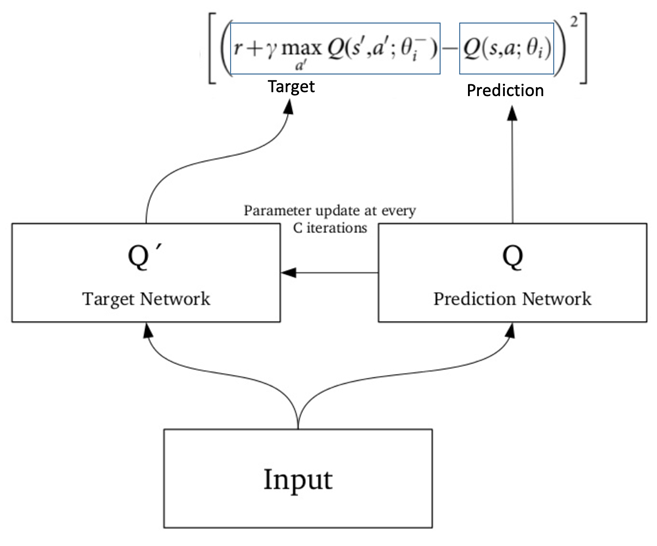


DQN leverages experience replay as a stabilization mechanism. Experience replay collects a buffer of historical transition models and randomly inserts the transition values during the Q-update function because we want to replicate the Temporal Difference target operation using our neural network rather than using a Q-table

In [ ]:
# # !pip install keras
# !pip install keras-rl2

In [1]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy

In [2]:
from keras import backend

In [3]:
import gym 
import random
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt 
import numpy as np
# import keras.backend as K

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [6]:
env = gym.make('MountainCar-v0')

Episode:1 Score:-200.0
Episode:2 Score:-200.0
Episode:3 Score:-200.0
Episode:4 Score:-200.0
Episode:5 Score:-200.0
Episode:6 Score:-200.0
Episode:7 Score:-200.0
Episode:8 Score:-200.0
Episode:9 Score:-200.0
Episode:10 Score:-200.0


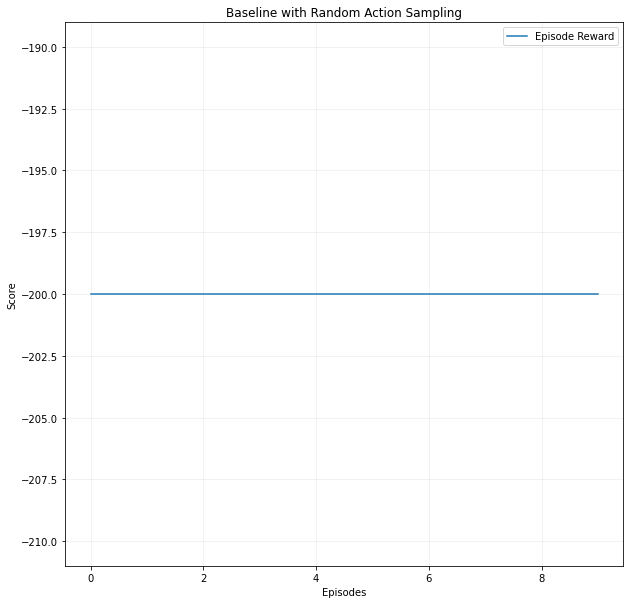

In [7]:
episodes = 10

# episode_list = []
score_list = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = random.choice([0,1])
        n_state, reward, done, info = env.step(action)
        score+=reward       
    print('Episode:{} Score:{}'.format(episode, score))
    score_list.append(score)
    
fig = plt.figure(figsize=(10,10))
plt.plot(range(episodes), score_list, label="Episode Reward")
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('Baseline with Random Action Sampling')
plt.grid(alpha=0.2)
plt.legend()

### We Build our model here 

#### The first layer has to be flattened in the shape of (1,states)
#### While the last layer has to be of the shape of action.

In [8]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [9]:

env.reset()
states = env.observation_space.shape[0]
actions = env.action_space.n

print(states)
print(actions)

2
3


In [10]:
model = build_model(states, actions)

In [11]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=50000, window_length=1)
    policy = EpsGreedyQPolicy()
    dqn = DQNAgent(model=model, nb_actions=actions, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)
    return dqn

In [12]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=1000000, visualize=False, verbose=1,nb_max_episode_steps=99, log_interval=100000)


Training for 1000000 steps ...
Interval 1 (0 steps performed)
   399/100000 [..............................] - ETA: 37s - reward: -1.0000

C:\ProgramData\Anaconda3\envs\tfgym\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100000/100000 [==============================] - 364s 4ms/step - reward: -1.0000
1010 episodes - episode_reward: -99.000 [-99.000, -99.000] - loss: 7.720 - mae: 27.791 - mean_q: -40.989

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 371s 4ms/step - reward: -1.0000
1012 episodes - episode_reward: -98.818 [-99.000, -84.000] - loss: 1.965 - mae: 23.171 - mean_q: -33.875

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 355s 4ms/step - reward: -1.0000
1012 episodes - episode_reward: -98.808 [-99.000, -86.000] - loss: 0.538 - mae: 23.168 - mean_q: -33.674

Interval 4 (300000 steps performed)
100000/100000 [==============================] - 368s 4ms/step - reward: -1.0000
1012 episodes - episode_reward: -98.740 [-99.000, -84.000] - loss: 0.691 - mae: 23.340 - mean_q: -33.995

Interval 5 (400000 steps performed)
100000/100000 [==============================] - 364s 4ms/step - reward: -1.0000
1011 episodes - episode_rew

In [24]:
scores = dqn.test(env, nb_episodes=9000, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 9000 episodes ...
Episode 1: reward: -84.000, steps: 84
Episode 2: reward: -157.000, steps: 157
Episode 3: reward: -148.000, steps: 148
Episode 4: reward: -177.000, steps: 177
Episode 5: reward: -149.000, steps: 149
Episode 6: reward: -148.000, steps: 148
Episode 7: reward: -87.000, steps: 87
Episode 8: reward: -155.000, steps: 155
Episode 9: reward: -200.000, steps: 200
Episode 10: reward: -149.000, steps: 149
Episode 11: reward: -153.000, steps: 153
Episode 12: reward: -85.000, steps: 85
Episode 13: reward: -200.000, steps: 200
Episode 14: reward: -177.000, steps: 177
Episode 15: reward: -93.000, steps: 93
Episode 16: reward: -200.000, steps: 200
Episode 17: reward: -161.000, steps: 161
Episode 18: reward: -149.000, steps: 149
Episode 19: reward: -149.000, steps: 149
Episode 20: reward: -148.000, steps: 148
Episode 21: reward: -84.000, steps: 84
Episode 22: reward: -148.000, steps: 148
Episode 23: reward: -149.000, steps: 149
Episode 24: reward: -148.000, steps: 148
Episo

KeyboardInterrupt: 

In [16]:
score_l = scores.history['episode_reward']
score_mean=[]
for i in score_time:
    score_mean = np.append(score_mean,np.mean(score_l[i:i+500]))

In [15]:
score_time = np.arange(0,9000,400)
score_time

array([   0,  400,  800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000,
       4400, 4800, 5200, 5600, 6000, 6400, 6800, 7200, 7600, 8000, 8400,
       8800])

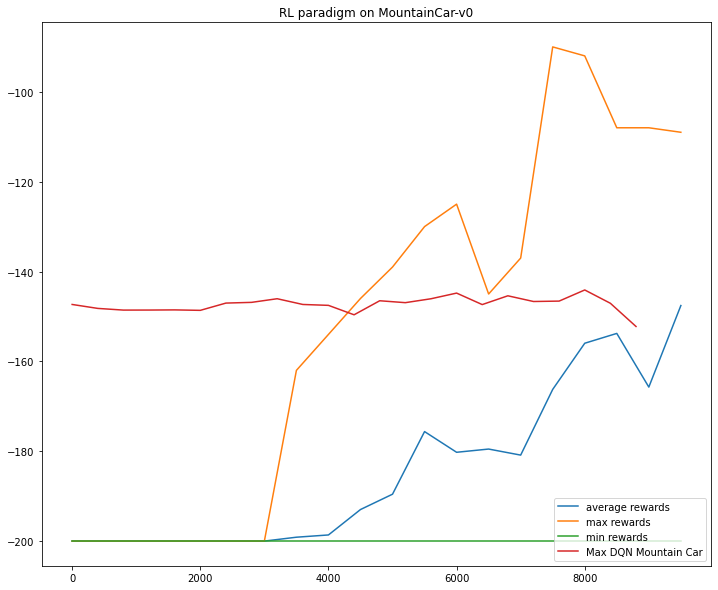

In [23]:
plt.figure(figsize=(12,10))
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.plot(score_time,score_mean, label = "Max DQN Mountain Car")
plt.title("RL paradigm on MountainCar-v0")
plt.legend(loc=4)

plt.show()